In [3]:
import cv2
import numpy as np
import os
from skimage.filters.rank import entropy
from skimage.morphology import square
import copy
import time
import matplotlib.pyplot as plt

In [4]:
def sharpness_map1(img):
    def dctmtx(n):
        [mesh_cols, mesh_rows] = np.meshgrid(np.linspace(0, n-1, n), np.linspace(0, n-1, n))
        dct_matrix = np.sqrt(2/n) * np.cos(np.pi * np.multiply((2 * mesh_cols + 1), mesh_rows) / (2*n));
        dct_matrix[0, :] = dct_matrix[0, :] / np.sqrt(2)
        return(dct_matrix)
    
#Domain Transform for Edge-Aware Image and Video Processing

    def getDCTCoefficients(img_blk, ind):
        rows, cols = np.shape(img_blk)
        # D = self.__dctmtx(rows)
        D = dct_matrices[ind]
        dct_coeff = np.matmul(np.matmul(D, img_blk), np.transpose(D))
        return(dct_coeff)
    def TransformedDomainRecursiveFilter_Horizontal(I, D, sigma):
        # Feedback Coefficient (Appendix of the paper)
        a = np.exp(-np.sqrt(2) / sigma)
        F = copy.deepcopy(I)
        V = a ** D
        rows, cols = np.shape(I)

        # Left --> Right Filter
        for i in range(1, cols):
            F[:, i] = F[:, i] + np.multiply(V[:, i], (F[:, i-1] - F[:, i]))

        # Right --> Left Filter
        for i in range(cols-2, 1, -1):
            F[:, i] = F[:, i] + np.multiply(V[:, i+1], (F[:, i + 1] - F[:, i]))

        return(F)

    def RF(img, joint_img):
        if(len(joint_img) == 0):
            joint_img = img
        joint_img = joint_img.astype('float64')
        joint_img = joint_img / 255

        if(len(np.shape(joint_img)) == 2):
            cols, rows = np.shape(joint_img)
            channels = 1
        elif(len(np.shape(joint_img)) == 3):
            cols, rows, channels = np.shape(joint_img)
        # Estimate horizontal and vertical partial derivatives using finite differences.
        dIcdx = np.diff(joint_img, n=1, axis=1)
        dIcdy = np.diff(joint_img, n=1, axis=0)

        dIdx = np.zeros((cols, rows));
        dIdy = np.zeros((cols, rows));

        # Compute the l1 - norm distance of neighbor pixels.
        dIdx[:, 1::] = abs(dIcdx)
        dIdy[1::, :] = abs(dIcdy)
        sigma_s_RF_filter = 15
        sigma_r_RF_filter = 0.25
        dHdx = (1 + sigma_s_RF_filter / sigma_r_RF_filter * dIdx)
        dVdy = (1 + sigma_s_RF_filter / sigma_r_RF_filter * dIdy)

        dVdy = np.transpose(dVdy)
        N = 3
        F  = copy.deepcopy(img) 
        for i in range(3):
            # Compute the sigma value for this iteration (Equation 14 of our paper).
            sigma_H_i = sigma_s_RF_filter * np.sqrt(3) * 2 ** (N - (i + 1)) / np.sqrt(4 ** N - 1)
            F = TransformedDomainRecursiveFilter_Horizontal(F, dHdx, sigma_H_i)
            F = np.transpose(F)

            F = TransformedDomainRecursiveFilter_Horizontal(F, dVdy, sigma_H_i)
            F = np.transpose(F)

        return(F)
    
    InputImageGaus = cv2.GaussianBlur(img, (3, 3), sigmaX=0.5, sigmaY=0.5)
    sobelx = cv2.Sobel(InputImageGaus, cv2.CV_64F, 1, 0, borderType=cv2.BORDER_REFLECT)  
    sobely = cv2.Sobel(InputImageGaus, cv2.CV_64F, 0, 1, borderType=cv2.BORDER_REFLECT)

    # Find gradient magnitude
    magnitude = np.sqrt(sobelx ** 2.0 + sobely ** 2.0)
    gradient_image = magnitude
    
    num_scales = 4
    scales = []
    for i in range(num_scales):
        scales.append((2**(3 + i)) - 1)
    print(scales)
    total_num_layers = 1 + sum(scales)
    
    dct_matrices = []
    for curr_scale in scales:
        dct_matrix = dctmtx(curr_scale)
        dct_matrices.append(dct_matrix)
        
    freqBands = []
    for current_scale in scales:
        matrixInds = np.zeros((current_scale, current_scale))

        for i in range(current_scale):
            matrixInds[0 : max(0, int(((current_scale-1)/2) - i +1)), i] = 1

        for i in range(current_scale):
            if (current_scale-((current_scale-1)/2) - i) <= 0:
                matrixInds[0:current_scale - i - 1, i] = 2
            else:
                matrixInds[int(current_scale - ((current_scale - 1) / 2) - i - 1): int(current_scale - i - 1), i]=2;
        matrixInds[0, 0] = 3
        freqBands.append(matrixInds)
        
    freq_index = []
    for i in range(num_scales):
        curr_freq_band = freqBands[i]
        freq_index.append(np.where(curr_freq_band == 0))
        
    padded_image = np.pad(gradient_image, int(np.floor(max(scales)/2)), mode='constant')
    rows, cols = np.shape(padded_image)
    downsampling_factor = 4
    total_num_points = len([i for i in range(int(max(scales)/2), rows - int(max(scales)/2), downsampling_factor)]) * len([j for j in range(int(max(scales) / 2), cols - int(max(scales) / 2), downsampling_factor)])
    L = np.zeros((total_num_points, total_num_layers))

    iter = 0
    n = 0
    old_progress = 0
    for i in range(int(max(scales)/2), rows - int(max(scales)/2), downsampling_factor):
        m = 0
        n += 1
        for j in range(int(max(scales) / 2), cols - int(max(scales) / 2), downsampling_factor):
            m += 1
            high_freq_components = []
            for ind, curr_scale in enumerate(scales):
                Patch = padded_image[i-int(curr_scale/2) : i+int(curr_scale/2) + 1, j-int(curr_scale/2) : j+int(curr_scale/2) + 1]
                dct_coefficients = np.abs(getDCTCoefficients(Patch, ind))

                # store all high frequency components
                high_freq_components.append(dct_coefficients[freq_index[ind]])

            # Find the first `total_num_layers` smallest values in all the high frequency components - we must not sort the entire array since that is very inefficient
            high_freq_components = np.hstack(high_freq_components)
            result = np.argpartition(high_freq_components, total_num_layers)
            L[iter, :] = high_freq_components[result[:total_num_layers]]
            iter += 1

    L = np.array(L)
    # normalize the L matrix
    for i in range(total_num_layers):
        max_val = max(L[:, i])
        L[:, i] = L[:, i] / max_val
        
    ind1d = 0
    T_max = np.zeros((n, m))
    max_val = 0
    min_val = 99999
    for i in range(n):
        for j in range(m):
            T_max[i][j] = np.sqrt(np.sum(L[ind1d, :]**2))
            max_val = max(max_val, T_max[i][j])
            min_val = min(min_val, T_max[i][j])
            ind1d += 1
    T_max= T_max/T_max.max()
    local_entropy = entropy(T_max, square(7)) 
    weighted_local_entropy = np.multiply(local_entropy, T_max)
    
    rows, cols = np.shape(weighted_local_entropy)
    resized_input_image = cv2.resize(InputImageGaus, (cols, rows))
    aSmooth = cv2.GaussianBlur(resized_input_image, (3, 3), sigmaX=1, sigmaY=1)
    final_map = RF(weighted_local_entropy, aSmooth)
    
    ori_rows, ori_cols = np.shape(img)
    final_map = cv2.resize(final_map, (ori_cols, ori_rows))
    #plt.imshow(final_map,cmap='gray')
    return final_map


In [5]:
img = cv2.imread(r"D:\data\Focal_stack\balls\a24.jpg",0)

In [6]:
final_map = sharpness_map1(img)

[7, 15, 31, 63]


C:\Users\ANKIT\AppData\Local\Temp\ipykernel_7832\3182163166.py:158: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  local_entropy = entropy(T_max, square(7))


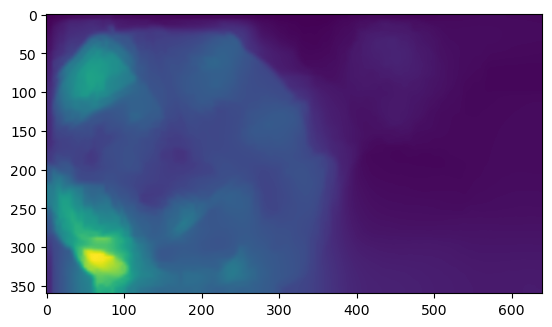

In [9]:
plt.imshow(final_map)

In [10]:
path = r"D:\data\New folder"
ls = os.listdir(path)
fram_ls1 = []
for i in ls[::3]:
    image = cv2.imread(path+"\\"+i,0)
    final_map = sharpness_map1(image)
    fram_ls1.append(final_map)

[7, 15, 31, 63]


C:\Users\ANKIT\AppData\Local\Temp\ipykernel_7832\3182163166.py:158: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  local_entropy = entropy(T_max, square(7))


[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]
[7, 15, 31, 63]


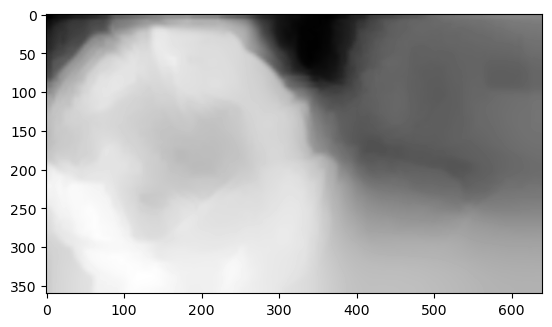

In [11]:
d1 = np.sum(np.array(fram_ls1), axis= 0)
k1 = 1
n_c1 = []
for i in fram_ls1/d1:
    n_c1.append(i*k1)
    k1+=1
mm1 = np.sum(n_c1, axis=0)
plt.imshow(mm1,cmap='gray')

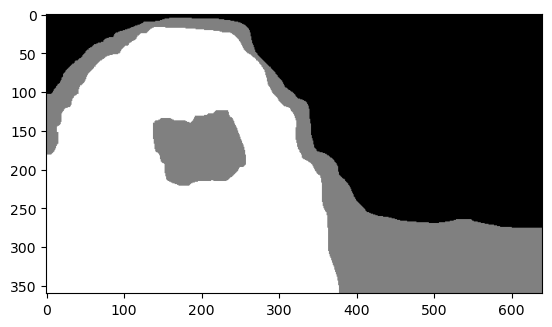

In [13]:
depth_map = cv2.normalize(mm1, None, 0, 255, cv2.NORM_MINMAX)
# Define foreground and background thresholds (adjust these values as needed)
foreground_threshold = 200  # Example threshold for foreground
background_threshold = 150  # Example threshold for background

# Thresholding to segment the depth map
foreground_mask = (depth_map > foreground_threshold).astype(np.uint8)
background_mask = (depth_map < background_threshold).astype(np.uint8)

# Perform morphological operations (dilation and erosion) for smoother transitions
kernel = np.ones((5, 5), np.uint8)
foreground_mask = cv2.dilate(foreground_mask, kernel, iterations=3)
background_mask = cv2.dilate(background_mask, kernel, iterations=3)
foreground_mask = cv2.erode(foreground_mask, kernel, iterations=3)
background_mask = cv2.erode(background_mask, kernel, iterations=3)

# Create the trimap
trimap = np.zeros_like(depth_map)
trimap[foreground_mask == 1] = 255  # Foreground
trimap[background_mask == 1] = 0    # Background
trimap[(foreground_mask == 0) & (background_mask == 0)] = 128  # Uncertain region

plt.imshow(trimap, cmap='gray')

(-0.5, 639.5, 359.5, -0.5)

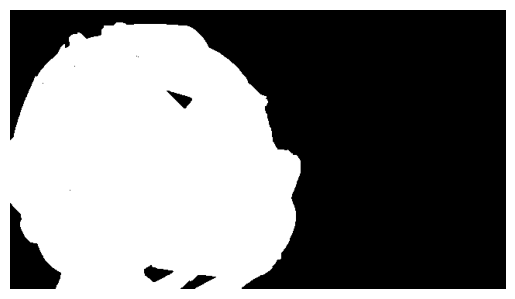

In [17]:
image = cv2.imread(r"D:\data\Focal_stack\balls\a24.jpg")

# Read the trimap (0 for background, 128 for uncertain, 255 for foreground)
#trimap = cv2.imread('trimap.png', cv2.IMREAD_GRAYSCALE)

# Create a mask for the foreground and background
mask = np.zeros(image.shape[:2], dtype=np.uint8)
mask[trimap == 0] = cv2.GC_BGD  # Background
mask[trimap == 128] = cv2.GC_PR_BGD  # Probable background
mask[trimap == 255] = cv2.GC_FGD  # Foreground
mask[trimap == 255] = cv2.GC_PR_FGD  # Probable foreground

# Apply GrabCut algorithm
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
rect = None  # You can specify a rectangle to initialize GrabCut, or set it to None
iter_count = 5  # Number of iterations for GrabCut algorithm
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, iterCount=iter_count, mode=cv2.GC_INIT_WITH_MASK)

# Extract the final segmented mask (grabcut output)
segmented_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
plt.imshow(segmented_mask,cmap='gray')

plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

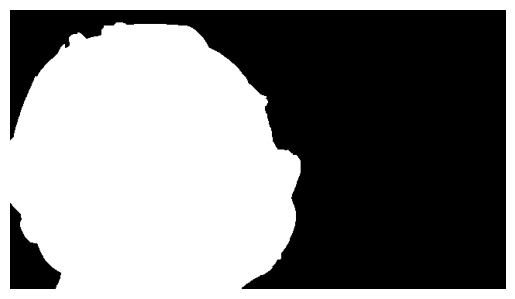

In [18]:
def remove_noise(binary_mask, min_area_threshold):
    # Find connected components in the binary mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    # Create a mask to store the noise-free binary mask
    noise_free_mask = np.zeros_like(binary_mask)

    # Iterate through each connected component
    for label in range(1, num_labels):  # Skip background label (0)
        # Extract area of the connected component
        area = stats[label, cv2.CC_STAT_AREA]

        # Check if the area exceeds the minimum area threshold
        if area >= min_area_threshold:
            # Add the connected component to the noise-free mask
            noise_free_mask[labels == label] = 255

    return noise_free_mask

# Example usage:
# Load the binary mask (assuming it's already thresholded)
binary_mask = 255 - segmented_mask

# Set the minimum area threshold to remove noise
min_area_threshold = 1000

# Remove noise from the binary mask
noise_free_mask = remove_noise(binary_mask, min_area_threshold)

plt.imshow(255-noise_free_mask,cmap='gray')
plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

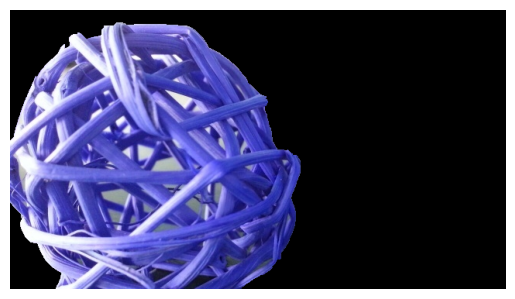

In [19]:
segmented_image = cv2.bitwise_and(image, image, mask=(255-noise_free_mask))

# Display the segmented image


plt.imshow(segmented_image)
plt.axis('off')